In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt

# 2.4 Approvisionnement d'un chantier (optimisation combinatoire)

__1) Modélisation du problème__

Notons $\textbf{a}=(a_{t})_{1\leq t\leq N}$ et $\textbf{r}=(r_{t})_{1\leq t\leq N}$ les vecteurs designant respectivement le nombre de machine à ajouter et retirer au temps $t$.

Chaque semaine, l'entreprise paye donc $a_{t}p^{\text{init}}$ de frais de mise en service et $r_{t}p^{\text{fin}}$ de frais de restitution. 

De plus, en prenant la somme sur les semaines passées des ajouts moins les retraits, on obtient le nombre de machine actuellement louées. On en déduit que l'entreprise paye également chaque semaine $\left(\sum_{i=0}^{t}a_{i}-r_{i}\right)p^{\text{loc}}$ de frais de location.

On peut ainsi définir une fonction de frais dépensé sur la durée du chantier par :

$$J(\textbf{a},\textbf{r}) = \sum_{t=0}^{N}\left[a_{t}p^{\text{init}}+r_{t}p^{\text{fin}}+\sum_{i=0}^{t}(a_{i}-r_{i})p^{\text{loc}}\right]$$

De plus, on doit vérifier les contraintes suivantes :

- Aucun retour de machine possible la première semaine $\Rightarrow r_{1}=0$
- Le nombre de machine louée sur une semaine donnée doit toujours être supérieur au nombre de machines requises $\Rightarrow \forall t\in [\![1,N]\!],\enspace \sum_{i=0}^{t}a_{i}-r_{i} \geq d_{t}$
- Tout est rendu et rien n'est ajouté lors de la dernière semaine $\Rightarrow \sum_{i=0}^{N}a_{i}-r_{i} = 0$

Finalement, les vecteurs $\textbf{a}$ et $\textbf{r}$ étant des vecteurs entiers de $\mathbb{N}^{N}$, en notant $x = (\textbf{a},\textbf{r})$, on peut poser le problème comme le problème de programmation linéaire en nombre entier suivant :

$$ (\mathcal{P}) : \underset{x\in\mathbb{N}^{2N}}{\min}J(x) \quad \text{s.c}\enspace
\begin{matrix} r_{1}=0 \\
\sum_{i=0}^{t}a_{i}-r_{i} \geq d_{t}\,, \forall t\;\\ 
\sum_{i=0}^{N}a_{i}-r_{i} = 0
\end{matrix}
$$

__2) Résolution__

Chargement des données

In [2]:
filePath = "data/DonneesEnginsChantier.txt"

with open(filePath, "rb") as f:
    d = f.readline()
    d = d.split()
    d = np.array(d).astype(float)
    d = d.astype(int)
N = len(d)

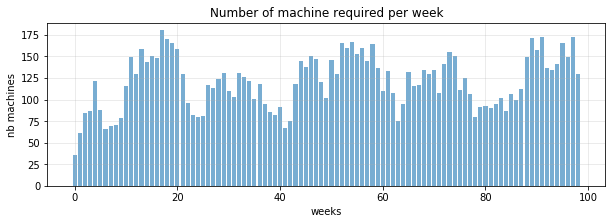

In [3]:
plt.figure(figsize=(10,3))
plt.bar(range(N), d, alpha=0.6)
plt.xlabel("weeks")
plt.ylabel("nb machines")
plt.grid(alpha=0.3)
plt.title("Number of machine required per week", size=12)
plt.show()

On définit les coûts unitaires donnés dans l'énoncé

In [4]:
p_init = 800
p_fin = 1200
p_loc = 200

In [5]:
# Variable d'optimisation
X = cvxpy.Variable((2,N), integer=True)

# Contraintes
constraint_init = [X[1,0]==0]   #contrainte initiale
constraint_supplies = [cvxpy.sum(X[0,:i]-X[1,:i]) >= d[i] for i in range(1,N)]  #contrainte besoins hebdomadaires
constraints_end = [cvxpy.sum(X[0]-X[1])==0]  #contrainte finale
contraints_sign = [X[0,i] >= 0 for i in range(N)] + [X[1,i] >= 0 for i in range(N)]  #vecteurs positifs

constraints = constraint_init + constraint_supplies + constraints_end + contraints_sign

Définition de fonction de coût à minimiser

In [6]:
total_cost = p_init*cvxpy.sum(X[0]) + p_fin*cvxpy.sum(X[1])
for i in range(1,N):
    total_cost += p_loc*(cvxpy.sum(X[0,:i]-X[1,:i]))

Minimisation par solver `ECOS_BB`, un solver de type "branch-and-bound" adapté aux problème de type mixed-integer

In [7]:
chantier_pd = cvxpy.Problem(cvxpy.Minimize(total_cost), constraints=constraints)
optimal_strategy = chantier_pd.solve(solver=cvxpy.ECOS_BB)

print("Optimal total cost : ", round(optimal_strategy,1))

Optimal total cost :  3304000.0


> Le coût optimal obtenu est donc de 3304000

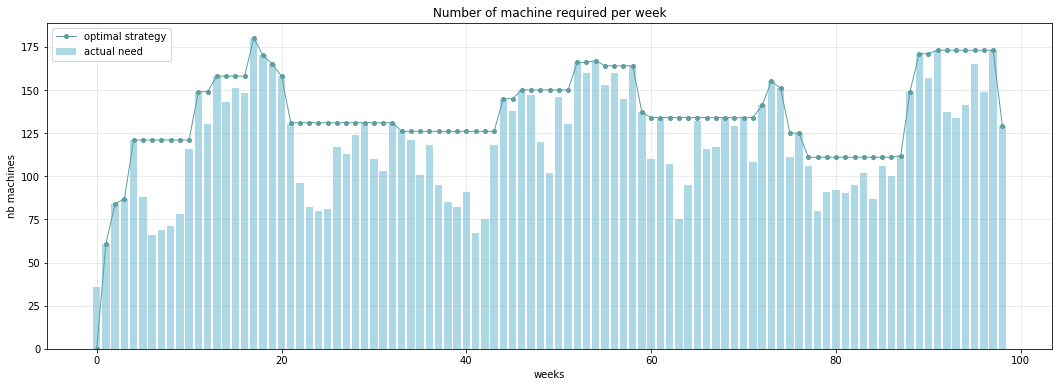

In [8]:
a = X.value[0]
r = X.value[1]
optimal_stock = [np.sum(a[:i]-r[:i]) for i in range(N)]

plt.figure(figsize=(18,6))
plt.bar(range(N), d, color="lightblue", label="actual need")
plt.plot(range(N), optimal_stock, '-o', color="cadetblue", linewidth=1, markersize=4, label="optimal strategy")
plt.xlabel("weeks")
plt.ylabel("nb machines")
plt.grid(alpha=0.3)
plt.title("Number of machine required per week")
plt.legend()
plt.show()

On remarque que $p^{\text{init}}+p^{\text{fin}} = 10p^{\text{loc}}$. Ainsi, en terme de coût, les 2 process suivants sont équivalents :

$$\underbrace{\text{ajout machine}}_{p^{\text{init}}}\longrightarrow\underbrace{\text{location 10 semaines}}_{10p^{\text{loc}}}\longrightarrow\underbrace{\text{restitution}}_{p^{\text{fin}}}$$

$$\underbrace{\text{ajout machine}}_{p^{\text{init}}}\longrightarrow\underbrace{\text{restitution}}_{p^{\text{fin}}}\longrightarrow\underbrace{\text{ajout machine}}_{p^{\text{init}}}\longrightarrow\underbrace{\text{restitution}}_{p^{\text{fin}}}$$

On en déduit qu'une stratégie optimale intuitive consiste à ne conserver une machine que si sa durée de location n'excède pas 10 semaines, autrement il est plus intéressant de la restituer pour la relouer après.

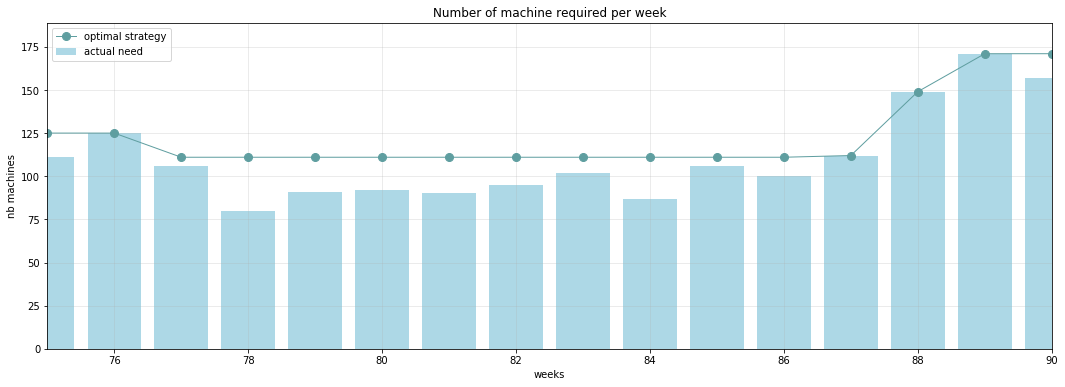

In [9]:
plt.figure(figsize=(18,6))
plt.bar(range(N), d, color="lightblue", label="actual need")
plt.plot(range(N), optimal_stock, '-o', color="cadetblue", linewidth=1, markersize=8, label="optimal strategy")
plt.xlabel("weeks")
plt.ylabel("nb machines")
plt.grid(alpha=0.3)
plt.xlim(75,90)
plt.title("Number of machine required per week")
plt.legend()
plt.show()

Cette stratégie est cohérente avec la stratégie optimale observée entre les semaines 77 et 87 durant lesquelles le nombre de machines louées est supérieur au besoin car il coûterait plus cher de les restituer pour les relouer en vue de la semaine 87